In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import classification_report

In [ ]:
batch_size = 32
learning_rate = 3e-4
epochs = 20
image_size = 16
channels = 3

In [ ]:
# Define the transformation for the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(image_size),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and import the training set
train_dataset = datasets.USPS(root='./data', train=True, transform=transform, download=True)
test_data = datasets.USPS(root='./data', train=False, transform=transform, download=True)


# Splitting dataset into train, val and test sets
train_data, val_data = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

In [ ]:
train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size= batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size= batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CNN(nn.Module):
    def __init__(self, neurons):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(neurons[0], neurons[1], kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size =2, stride = 2),
            nn.Conv2d(neurons[1], neurons[2], kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size =2, stride = 2),
            nn.Conv2d(neurons[2], neurons[3], kernel_size = 3, stride = 1, padding = 1)
        )
        self.fc = nn.Linear(640, 10)

    def forward(self, x):
#         print(x.shape)
        x = self.cnn(x)
#         print(x.shape)
        x = x.view(x.shape[0], -1)
#         print(x.shape)
        x = self.fc(x)
#         print(x.shape)
        return x

In [ ]:
cnn_model = CNN([1, 100, 50, 40]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr= learning_rate)

In [ ]:
t_loss_cnn = []
v_loss_cnn = []

for epoch in range(epochs):
    cnn_model.train()
    loss = 0

    for features, label in train_loader:
        # Convolutional layers getting input of size
        features = features.to(device)
        label = label.to(device)


        optimizer.zero_grad()
        # Gradients are being set to 0 so that they don't get accumulated, as the pytorch library was built like this

        outputs = cnn_model(features)
        # Features being put in the model

        train_loss = criterion(outputs, label)
        # train_loss being calculated

        train_loss.backward()
        # Gradients being calculated

        loss = loss + train_loss.item()
        # add the mini-batch training loss to epoch loss

        optimizer.step()
        # perform parameter update based on current gradients

    loss = loss/len(train_loader)
    # compute the epoch training loss

    t_loss_cnn.append(loss)

    val_loss = 0

# Using torch.no_grad(), so that unnecessary gradients don't get stored
    with torch.no_grad():
        for features, label in val_loader:
            features = features.to(device)
            label = label.to(device)

            outputs = cnn_model(features)
            valid_loss = criterion(outputs, label)
            val_loss += valid_loss.item()

    val_loss = val_loss/len(val_loader)
    v_loss_cnn.append(val_loss)

    # display the epoch losses
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
    print("epoch : {}/{}, valid loss = {:.8f}".format(epoch + 1, epochs, val_loss))

epoch : 1/20, recon loss = 0.79445550
epoch : 1/20, valid loss = 0.25427446
epoch : 2/20, recon loss = 0.20933379
epoch : 2/20, valid loss = 0.17931379
epoch : 3/20, recon loss = 0.13958449
epoch : 3/20, valid loss = 0.13459092
epoch : 4/20, recon loss = 0.10243994
epoch : 4/20, valid loss = 0.10869178
epoch : 5/20, recon loss = 0.07793592
epoch : 5/20, valid loss = 0.09221570
epoch : 6/20, recon loss = 0.06405244
epoch : 6/20, valid loss = 0.08294800
epoch : 7/20, recon loss = 0.05379853
epoch : 7/20, valid loss = 0.08250569
epoch : 8/20, recon loss = 0.04150045
epoch : 8/20, valid loss = 0.06787641
epoch : 9/20, recon loss = 0.03274372
epoch : 9/20, valid loss = 0.06757879
epoch : 10/20, recon loss = 0.02811575
epoch : 10/20, valid loss = 0.06021159
epoch : 11/20, recon loss = 0.02091689
epoch : 11/20, valid loss = 0.06813956
epoch : 12/20, recon loss = 0.02124700
epoch : 12/20, valid loss = 0.05491128
epoch : 13/20, recon loss = 0.01809166
epoch : 13/20, valid loss = 0.06097380
epoc

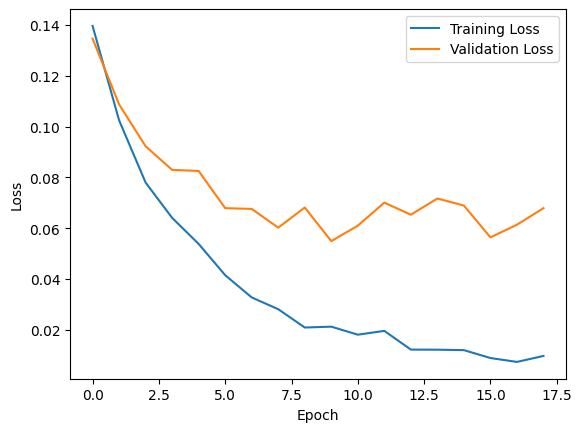

In [ ]:
plt.plot(t_loss_cnn[2:], label='Training Loss')
plt.plot(v_loss_cnn[2:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
cnn_model.eval()  # Switch model to evaluation mode

with torch.no_grad():
    all_predictions = []
    all_labels = []

    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = cnn_model(features)

        # Convert predictions and labels to numpy arrays
        predictions = outputs.argmax(dim=1).detach().cpu().numpy()
        # .extend() to add up all
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       359
           1       0.99      0.98      0.99       264
           2       0.98      0.93      0.96       198
           3       0.91      0.98      0.94       166
           4       0.93      0.93      0.93       200
           5       0.95      0.93      0.94       160
           6       0.98      0.98      0.98       170
           7       0.96      0.93      0.94       147
           8       0.97      0.91      0.94       166
           9       0.92      0.99      0.95       177

    accuracy                           0.96      2007
   macro avg       0.96      0.95      0.96      2007
weighted avg       0.96      0.96      0.96      2007



<Figure size 800x600 with 0 Axes>

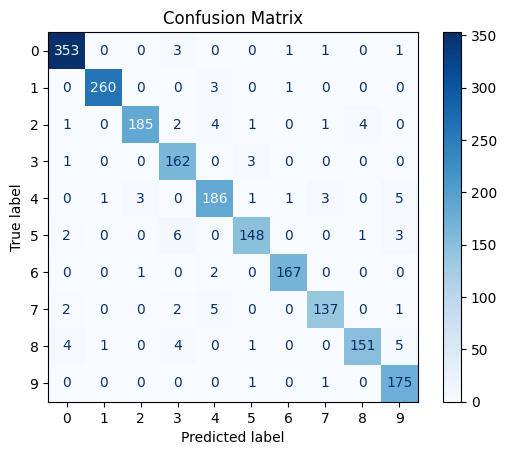

In [ ]:
# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[i for i in range(10)]).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()